**Install dependencies**

In [1]:
# %%capture
# try:
#     import miniai
# except ImportError:
#     !git clone https://github.com/fastai/course22p2.git
#     !pip install -e ./course22p2

In [9]:
# %%capture
# !pip install torch torchvision torchaudio torcheval
# !pip install numpy pandas pillow wandb
# !pip install -U cjm_pil_utils cjm_kaggle_utils cjm_pytorch_utils cjm_pandas_utils

**Import dependencies**

In [10]:
from pathlib import Path
import hashlib
import json
import random
import multiprocessing
import math
import os
from functools import partial
from copy import copy

from PIL import Image
import numpy as np
import timm
from tqdm.auto import tqdm

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torcheval.tools import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import fastai dependencies
import fastcore.all as fc
from miniai.datasets import DataLoaders
from miniai.conv import def_device
from miniai.learner import *
from miniai.activations import Hook, ActivationStats
from miniai.accel import MixedPrecision, AccelerateCB
from miniai.init import BatchTransformCB, GeneralRelu, init_weights, set_seed, conv
from miniai.sgd import BatchSchedCB
from miniai.resnet import ResBlock

# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, tensor_stats_df, get_torch_device
from cjm_pandas_utils.core import markdown_to_pandas

**Log into Weights & Biases**

In [11]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

**Set random number seeds**

In [12]:
set_seed(42)

**Set device and data type**

In [13]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

**Enter Kaggle username and API token**

In [15]:
username = "innominate817"
key = "ecd251fe774bd001fe5d1fa38e9ff600"

**Save Kaggle credentials to file**

In [16]:
save_kaggle_creds(username, key, overwrite=False)

**Define directory paths**

In [17]:
# Define path to store datasets
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: Datasets
Archive Directory: Datasets/../Archive


**Define Kaggle dataset**

In [18]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k'
# dataset_name = 'hagrid-classification-512p-no-gesture-300k'
# dataset_name = 'hagrid-classification-512p-no-gesture'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: Datasets/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path: Datasets/hagrid-classification-512p-no-gesture-150k


**Download Kaggle dataset**

In [19]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

100%|██████████| 3.57G/3.57G [00:27<00:00, 142MB/s] 


**Get image classes**

In [20]:
folders = [folder for folder in dataset_path.glob('*/') if folder.is_dir()]

class_names = [f.name for f in folders]

# print the list of class names
pd.DataFrame(class_names)

,0
0,peace
1,fist
2,call
3,four
4,peace_inverted
5,mute
6,ok
7,rock
8,two_up_inverted
9,one


**Get image paths**

In [21]:
img_paths = [get_img_files(folder) for folder in folders]
img_paths = [path for class_paths in img_paths for path in class_paths]
len(img_paths)

154816

**Display sample image**

Class: peace_inverted


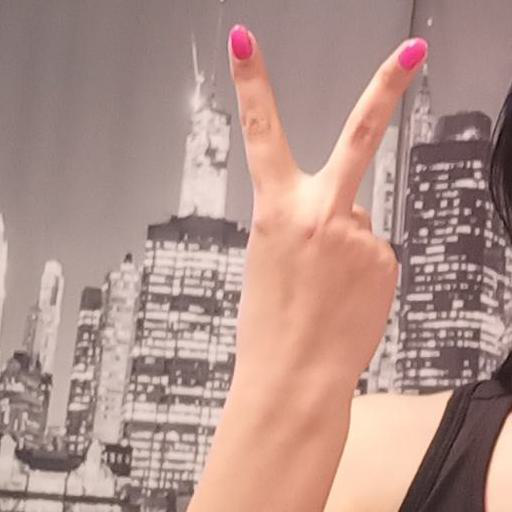

In [22]:
# Choose a random image ID from the list of image IDs
img_path = random.choice(img_paths)

print(f"Class: {img_path.parent.name}")

sample_img = Image.open(img_path)
sample_img

**Random Square Copy Transform**

In [23]:
def rand_square_copy(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]
    return x

In [24]:
class RandSquareCopy(nn.Module):
    def __init__(self, pct=0.2, min_num=0, max_num=4):
        super().__init__()
        fc.store_attr()
    def forward(self, x): 
        for i in range(random.randint(self.min_num, self.max_num)):
            rand_square_copy(x, self.pct)
        return x

torch.Size([1, 3, 512, 512])


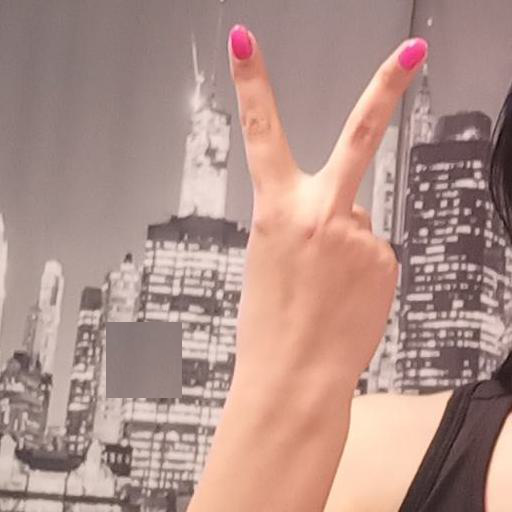

In [25]:
rand_square_copy_tf = RandSquareCopy(pct=0.15, min_num=1, max_num=1)

img_tensor = transforms.PILToTensor()(sample_img)[None]
print(img_tensor.shape)

tensor_to_pil(rand_square_copy_tf(img_tensor))

**Random Pixel Copy Transform**

In [26]:
def rand_pixel_copy(img_tensor, pct=0.2):
    # Get the dimensions of the image tensor
    b, c, h, w = img_tensor.shape
    
    num_pixels = int(img_tensor[-1:].numel()*pct)
    
    # Generate random indices for the pixels to be copied
    source_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
    source_indices[:, 0] = source_indices[:, 0] // w
    source_indices[:, 1] = source_indices[:, 1] % w
    
    # Generate random indices for the pixels to be replaced
    target_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
    target_indices[:, 0] = target_indices[:, 0] // w
    target_indices[:, 1] = target_indices[:, 1] % w
    
    # Copy the pixel values from the source indices to the target indices
    c_indices = torch.arange(c).repeat(num_pixels, 1).t()
    source_pixels = img_tensor[:, c_indices, source_indices[:, 0], source_indices[:, 1]]
    img_tensor[:, c_indices, target_indices[:, 0], target_indices[:, 1]] = source_pixels
    
    return img_tensor

In [27]:
class RandPixelCopy(nn.Module):
    def __init__(self, pct=0.1):
        super().__init__()
        fc.store_attr()
    def forward(self, x):
        return rand_pixel_copy(x, random.random()*self.pct)

torch.Size([1, 3, 512, 512])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


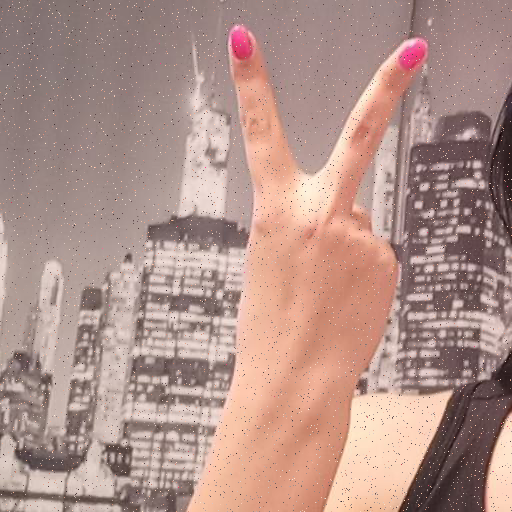

In [28]:
rand_pixel_copy_tf = RandPixelCopy(pct=0.015)

img_tensor = transforms.PILToTensor()(sample_img)[None]
print(img_tensor.shape)

tensor_to_pil(rand_pixel_copy_tf(img_tensor))

**Random Square Pixel Copy Transform**

In [29]:
def rand_square_pixel_copy(x, square_pct, pixel_pct):
    szx = int(square_pct*x.shape[-2])
    szy = int(square_pct*x.shape[-1])
    stx1 = int(random.random()*(1-square_pct)*x.shape[-2])
    sty1 = int(random.random()*(1-square_pct)*x.shape[-1])
    stx2 = int(random.random()*(1-square_pct)*x.shape[-2])
    sty2 = int(random.random()*(1-square_pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = rand_pixel_copy(x[:,:,stx2:stx2+szx,sty2:sty2+szy].clone(),pixel_pct)
    return x

In [30]:
class RandSquarePixelCopy(nn.Module):
    def __init__(self, square_pct=0.2, pixel_pct=1.0, min_num=0, max_num=4):
        super().__init__()
        fc.store_attr()
    def forward(self, x):
        for i in range(random.randint(self.min_num, self.max_num)):
            rand_square_pixel_copy(x, self.square_pct, self.pixel_pct)
        return x

torch.Size([1, 3, 512, 512])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


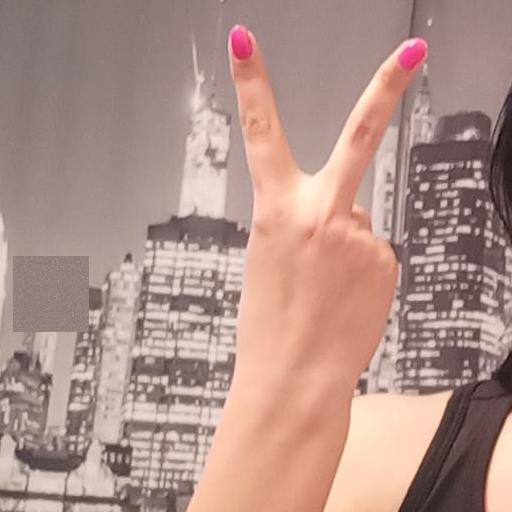

In [31]:
rand_square_pixel_copy_tf = RandSquarePixelCopy(square_pct=0.15, pixel_pct=1.0, min_num=1, max_num=1)

img_tensor = transforms.PILToTensor()(sample_img)[None]
print(img_tensor.shape)

tensor_to_pil(rand_square_pixel_copy_tf(img_tensor))

**Resize Pad Transform**

In [32]:
class ResizePad(nn.Module):
    def __init__(self, max_sz=256, padding_mode='edge'):
        super().__init__()
        self.max_sz = max_sz
        self.padding_mode = padding_mode
        
    def forward(self, x): 
        w,h = TF.get_image_size(x)
        size = int(min(w,h)/(max(w,h)/self.max_sz))
        x = TF.resize(x, size=size)
                
        w,h = TF.get_image_size(x)
        offset = (self.max_sz - min(w,h))//2
        padding = [0,offset] if h < w else [offset,0]
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode)
        x = TF.resize(x, size=[self.max_sz]*2)
        
        return x

Source image: (512, 512)
Cropped image: (512, 256)
Cropped tensor: torch.Size([1, 3, 256, 512])
Padded tensor: torch.Size([1, 3, 256, 256])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


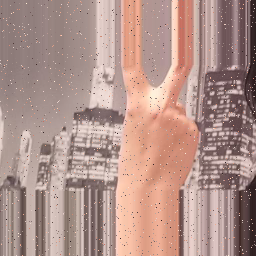

In [33]:
print(f"Source image: {sample_img.size}")
w, h = sample_img.size
cropped_img = sample_img.crop([0, h//4, w, h-h//4])
print(f"Cropped image: {cropped_img.size}")

resize_pad = ResizePad(max_sz=256)

img_tensor = transforms.PILToTensor()(cropped_img)[None]
print(f"Cropped tensor: {img_tensor.shape}")

resized_tensor = resize_pad(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

tensor_to_pil(rand_pixel_copy(resized_tensor, 0.0125))

**Trivial Augmentation**

torch.Size([1, 3, 512, 512])


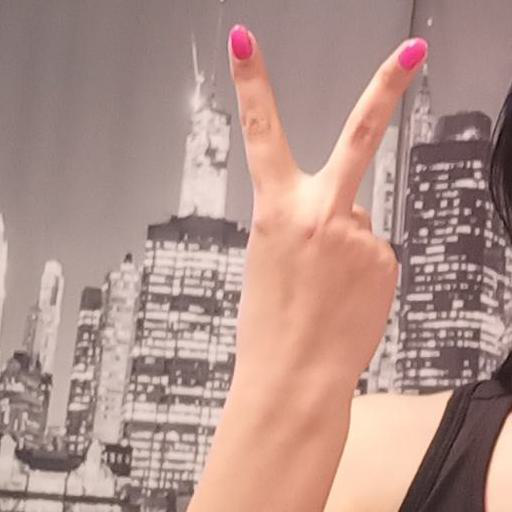

In [34]:
trivial_aug = transforms.TrivialAugmentWide()

img_tensor = transforms.PILToTensor()(sample_img)[None]
print(img_tensor.shape)

tensor_to_pil(trivial_aug(img_tensor))

**Define training dataset class**

In [35]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, classes, img_tfms):
        
        self.img_paths = img_paths
        
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
                
        self.img_tfms = img_tfms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        label = self.class_to_idx[img_path.parent.name]
        image = Image.open(img_path).convert('RGB')
        return self.img_tfms(image), label

**Set training and validation sets**

In [36]:
img_paths_subset = random.sample(img_paths, 70000)
# img_paths_subset = random.sample(img_paths, len(img_paths))

random.shuffle(img_paths_subset)

train_percentage = 0.9

split_index = int(len(img_paths_subset)*train_percentage)

train_paths = img_paths_subset[:split_index]
val_path = img_paths_subset[split_index:]

**Set training batch size**

In [37]:
bs = 32

**Initialize datasets**

In [38]:
train_sz = (256,256)

imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

img_tfms = transforms.Compose([
#     transforms.Resize(train_sz),
    ResizePad(max_sz=256),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
])

train_dataset = ImageDataset(img_paths=train_paths, 
                             classes=class_names,
                             img_tfms=img_tfms)

valid_dataset = copy(train_dataset)
valid_dataset.img_paths = val_path

len(train_dataset), len(valid_dataset)

(63000, 7000)

**Inspect dataset sample**

In [39]:
tensor_stats_df(train_dataset[0][0])

,0
mean,0.929841
std,0.821068
min,-1.70691
max,2.587713
shape,"(3, 256, 256)"


**Initialzie dataloaders**

In [40]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=bs, 
                              shuffle=True, 
                              num_workers=multiprocessing.cpu_count())

valid_dataloader = DataLoader(valid_dataset, batch_size=bs)

dls = DataLoaders(train_dataloader, valid_dataloader)

# Print the number of batches in the training and validation dataloaders
len(dls.train), len(dls.valid)

(1969, 219)

**List available ResNet18 models**

In [41]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

,0
0,resnet18
1,resnet18d


**Inspect config for ResNet18 model**

In [42]:
# Import the convnext module
from timm.models import resnet

# Choose the resnet model
resnet_model = 'resnet18d'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(resnet.default_cfgs[resnet_model], orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth
num_classes,1000
input_size,"(3, 224, 224)"
pool_size,"(7, 7)"
crop_pct,0.875
interpolation,bicubic
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"
first_conv,conv1.0
classifier,fc


**Load ResNet18 model**

In [43]:
# Load the resenet model
resnet18 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type
resnet18 = resnet18.to(device=device, dtype=dtype).eval()
resnet18.device = device

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth" to /root/.cache/torch/hub/checkpoints/resnet18d_ra2-48a79e06.pth


**List available ConvNeXt Nano models**

In [44]:
pd.DataFrame(timm.list_models('convnext_nano*', pretrained=True))

,0
0,convnext_nano
1,convnext_nano_ols


**Inspect config for convnext model**

In [45]:
# Import the convnext module
from timm.models import convnext

# Choose the convnext model
convnext_model = 'convnext_nano'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(convnext.default_cfgs[convnext_model], orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/convnext_nano_d1h-7eb4bdea.pth
num_classes,1000
input_size,"(3, 224, 224)"
pool_size,"(7, 7)"
crop_pct,0.95
interpolation,bicubic
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"
first_conv,stem.0
classifier,head.fc


**Load convnext_nano model**

In [46]:
# Load the convnext model
convnext = timm.create_model(convnext_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type
convnext = convnext.to(device=device, dtype=dtype).eval()
convnext.device = device

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/convnext_nano_d1h-7eb4bdea.pth" to /root/.cache/torch/hub/checkpoints/convnext_nano_d1h-7eb4bdea.pth


**Select model**

In [47]:
model = resnet18
# model = convnext

**Get model summary**

In [48]:
# Define the input to the model
test_inp = torch.randn(1, 3, *train_sz).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

/opt/conda/lib/python3.7/site-packages/torcheval/tools/module_summary.py:247: UserWarning: Please install PyTorch 1.13 or higher to compute FLOPs: https://pytorch.org/get-started/locally/
  "Please install PyTorch 1.13 or higher to compute FLOPs: https://pytorch.org/get-started/locally/"


,Type,# Parameters,# Trainable Parameters,Size (bytes),In size,Out size
0,ResNet,11.2 M,11.2 M,44.9 M,"[1, 3, 256, 256]","[1, 19]"
2,Conv2d,864,864,3.5 K,"[1, 3, 256, 256]","[1, 32, 128, 128]"
5,Conv2d,9.2 K,9.2 K,36.9 K,"[1, 32, 128, 128]","[1, 32, 128, 128]"
8,Conv2d,18.4 K,18.4 K,73.7 K,"[1, 32, 128, 128]","[1, 64, 128, 128]"
14,Conv2d,36.9 K,36.9 K,147 K,"[1, 64, 64, 64]","[1, 64, 64, 64]"
19,Conv2d,36.9 K,36.9 K,147 K,"[1, 64, 64, 64]","[1, 64, 64, 64]"
23,Conv2d,36.9 K,36.9 K,147 K,"[1, 64, 64, 64]","[1, 64, 64, 64]"
28,Conv2d,36.9 K,36.9 K,147 K,"[1, 64, 64, 64]","[1, 64, 64, 64]"
33,Conv2d,73.7 K,73.7 K,294 K,"[1, 64, 64, 64]","[1, 128, 32, 32]"
38,Conv2d,147 K,147 K,589 K,"[1, 128, 32, 32]","[1, 128, 32, 32]"


In [49]:
class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, project:str, name:str=None, **metrics):
        fc.store_attr()
        self.train = False
        super().__init__(*ms, **metrics)
        
    def before_fit(self, learn): 
        if self.name:
            wandb.init(project=self.project, name=self.name, config=self.config)
        else:
            wandb.init(project=self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d): 
        if self.train: 
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else: 
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
        
    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model, (16, 3, 32, 32))
        s = (samples[-1] + 0.5).clamp(0,1)
        plt.clf()
        fig, axs = get_grid(16)
        for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn) 
        wandb.log({'loss':learn.loss})
        
    def after_epoch(self, learn):
        self.train = learn.training
        super().after_epoch(learn)

In [51]:
class OutOfBoundsCB(Callback):
    """
    A callback that exits the training session if the loss is not NaN or infinite.
    """
    def __init__(self, msg="Loss out of bounds"):
        fc.store_attr()
        
    def after_loss(self, learn):
        """
        Check if the loss is NaN or infinite.
        """
        if learn.loss.detach().isnan() or learn.loss.detach().isinf(): 
            print(self.msg)
            raise CancelFitException()

In [52]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [53]:
tfms = nn.Sequential(
#     RandSquareCopy(pct=0.15, max_num=1),
#     RandPixelCopy(pct=0.015), 
#     RandSquarePixelCopy(square_pct=0.15, pixel_pct=0.5, min_num=1, max_num=1),
)
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [54]:
lr = 1e-3
epochs = 5

**Configure Weights & Biases project**

In [55]:
project_name = "miniai_data_augmentation_kaggle"
run_name = "trivial-aug-item-1"
project_config = {'lr':lr, 'epochs':epochs}

**Initialize callbacks**

In [56]:
wandbcb =  WandBCB(config=project_config, 
                   project=project_name,
                   name=run_name,
                   accuracy=MulticlassAccuracy()
                  )

metrics = MetricsCB(accuracy=MulticlassAccuracy())

cbs = [MixedPrecision(), 
       OutOfBoundsCB(),
       DeviceCB(), 
       metrics, 
       ProgressCB(plot=False),
       wandbcb,
#        augcb,
      ]

**Set optimizer**

In [57]:
opt_func = partial(torch.optim.AdamW, eps=1e-5)

In [58]:
tmax = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, torch.nn.functional.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

In [59]:
learn.fit(epochs)

wandb: Currently logged in as: millscj. Use `wandb login --relogin` to force relogin


accuracy,loss,epoch,train
0.789,0.744,0,train
0.868,0.444,0,eval
0.898,0.331,1,train
0.898,0.356,1,eval
0.934,0.216,2,train
0.937,0.201,2,eval
0.961,0.124,3,train
0.963,0.114,3,eval
0.975,0.079,4,train
0.969,0.097,4,eval


loss,█▄▂▂▂▃▂▃▁▂▃▂▂▁▁▂▂▃▂▁▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁
train_accuracy,▁▅▆▇█
train_loss,█▄▂▁▁
val_accuracy,▁▃▆██
val_loss,█▆▃▁▁
loss,0.0153
train_accuracy,0.975
train_loss,0.079
val_accuracy,0.969
val_loss,0.097


**Test model**

Class: call
Predicted Class: call


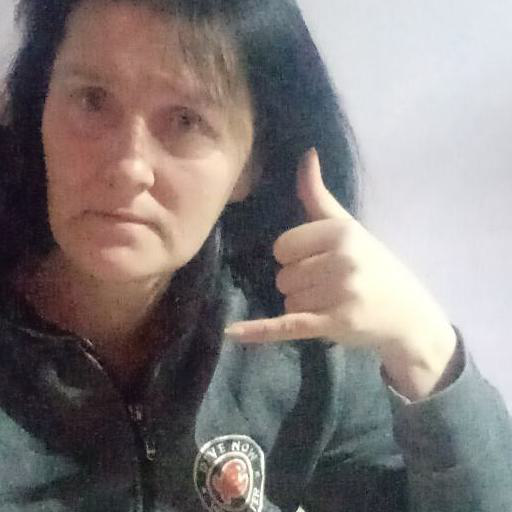

In [60]:
# Choose a random image ID from the list of image IDs
img_path = random.choice(img_paths)

print(f"Class: {img_path.parent.name}")

sample_img = Image.open(img_path)
inp_img = resize_img(sample_img.copy(), 288)

img_tensor = pil_to_tensor(inp_img, *imagenet_stats).to(device=device)

with torch.no_grad():
        pred = learn.model(img_tensor)
        
pred_class = train_dataset.classes[torch.argmax(torch.sigmoid(pred))]
        
print(f"Predicted Class: {pred_class}")


sample_img

In [61]:
img_dict = {path.stem: path for path in img_paths}

subset_dict = {path.stem: path for path in img_paths_subset}

test_paths = [path for k,path in img_dict.items() if k not in subset_dict]
len(test_paths)

79197

In [62]:
wrong_imgs = []

for path in tqdm(test_paths):
    target_cls = path.parent.name

    sample_img = Image.open(path)
    sample_img = resize_img(sample_img, 288)

    img_tensor = pil_to_tensor(sample_img, *imagenet_stats).to(device=device)

    with torch.no_grad():
            pred = learn.model(img_tensor)

    pred_cls = train_dataset.classes[torch.argmax(torch.sigmoid(pred))]
    
    if pred_cls != target_cls: wrong_imgs.append(path)

len(wrong_imgs)

  0%|          | 0/79197 [00:00<?, ?it/s]

765

In [63]:
# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path("./hagrid_checkpoints/")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Print the checkpoint path
checkpoint_dir

Path('hagrid_checkpoints')

In [64]:
torch.save(learn.model.state_dict(), checkpoint_dir/f"resnet18d-{run_name}.pth")

In [65]:
wrong_imgs_df = pd.DataFrame(wrong_imgs)
wrong_imgs_df['class'] = wrong_imgs_df.apply(lambda row: Path(row[0]).parent.stem, axis=1)

class_dist_df = wrong_imgs_df['class'].value_counts().to_frame().rename(columns={"class":run_name})
class_dist_df.rename_axis("class", inplace=True)
class_dist_df

,trivial-aug-item-1
class,
four,70
like,59
three,56
peace,55
two_up,51
no_gesture,45
call,44
fist,44
one,43


In [66]:
class_dist_df_path = checkpoint_dir/f"class_dist_df-{run_name}.json"
class_dist_df.to_json(class_dist_df_path)

In [67]:
# Import the 'os' and 'glob' modules
import os
from glob import glob

In [68]:
# Get a list of paths to JSON files in the 'annotation_dir' directory
df_paths = glob(os.path.join(checkpoint_dir, "*.json"))

# Display the JSON file paths using a Pandas DataFrame
pd.DataFrame(df_paths)

,0
0,hagrid_checkpoints/class_dist_df-trivial-aug-item-1.json


In [69]:
class_dist_dfs = (pd.read_json(f).rename_axis('class') for f in df_paths)

class_dist_agg_df = pd.concat(class_dist_dfs, axis=1, sort=False)

class_dist_agg_df

,trivial-aug-item-1
class,
call,44
dislike,32
fist,44
four,70
like,59
mute,20
no_gesture,45
ok,37
one,43


In [70]:
# Compute the sums along the columns axis
sums = class_dist_agg_df.sum(axis=0)

# Add a new row with the sums using the loc[] function
class_dist_agg_df.loc['Total'] = sums

class_dist_agg_df

,trivial-aug-item-1
class,
call,44
dislike,32
fist,44
four,70
like,59
mute,20
no_gesture,45
ok,37
one,43
